In [1]:
import os
import polars as pl
from src.plotting_functions import plot_transcript_class_hist
from src.utils import read_gtf, read_fasta
from Levenshtein import ratio
import seaborn as sns
import matplotlib.pyplot as plt
import orfipy_core
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

Loading required package: svglite

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# GENCODE V47

## Load Datasets

In [3]:
classification = pl.read_parquet("nextflow_results/V47/final_classification.parquet")

orfanage_pep = read_fasta("nextflow_results/V47/orfanage_peptide.fasta")
orfanage_stats = pl.read_csv("nextflow_results/V47/orfanage.stats", separator = "\t")

TD_gtf = read_gtf("nextflow_results/V47/transdecoder.gtf")
TD_pep = read_fasta("nextflow_results/V47/final_transcripts.fasta.transdecoder.pep")\
    .with_columns(
        pl.col("transcript_id").str.extract(r"^(.*)\.p\d+$")
    )

gencode_pep = read_fasta("".join([os.getenv("GENOMIC_DATA_DIR"), "GENCODE/gencode.v47.pc_translations.fa"]), gencode=True)
ensembl_gtf = read_gtf("".join([os.getenv("GENOMIC_DATA_DIR"), "Ensembl/Homo_sapiens.GRCh38.113.chr.gtf"]), attributes=["transcript_id", "gene_id", "gene_name"])
gencode_gtf = read_gtf("".join([os.getenv("GENOMIC_DATA_DIR"), "GENCODE/gencode.v47.annotation.gtf"]))



/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/utils.py:6960: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(sequences, schema=["transcript_id", "seq"])


## Reference-match isoforms

Text(0.5, 1.0, "Levenshtein distance between predicted \nand reference peptides of 'reference_match' isoforms")

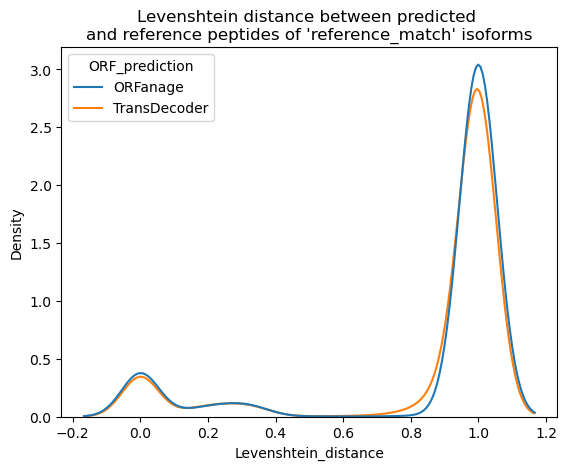

In [4]:
def get_df_for_pep(sample_pep):
    reference_match = sample_pep\
        .join(
            classification["isoform", "associated_transcript", "subcategory"].rename({"isoform": "transcript_id"}),
            on = "transcript_id",
            how = "left"
        )\
        .filter(pl.col("subcategory") == "reference_match")\
        .join(
            gencode_pep["transcript_id", "seq"].rename({"seq": "gencode_seq", "transcript_id": "associated_transcript"}),
            on = "associated_transcript",
            how = "left"
        )

    return reference_match\
        .with_columns(
                reference_match.map_rows(lambda row: ratio(row[1], row[4]))
        )\
        .rename({"map": "Levenshtein_distance"})\
        .select(["transcript_id", "Levenshtein_distance"])

df  = pl.concat(
    [
        get_df_for_pep(orfanage_pep).with_columns(ORF_prediction = pl.lit("ORFanage")), 
        get_df_for_pep(TD_pep).with_columns(ORF_prediction = pl.lit("TransDecoder"))
        ],
    how="vertical")
fig, ax = plt.subplots()
sns.kdeplot(df, x = "Levenshtein_distance", hue="ORF_prediction", ax = ax)
ax.set_title("Levenshtein distance between predicted \nand reference peptides of 'reference_match' isoforms")

In [11]:
get_df_for_pep(orfanage_pep).filter(pl.col("Levenshtein_distance") == 1).shape[0]/get_df_for_pep(orfanage_pep).shape[0]



0.8298056690184429

In [12]:
get_df_for_pep(TD_pep).filter(pl.col("Levenshtein_distance") == 1).shape[0]/get_df_for_pep(TD_pep).shape[0]

0.6881131354312652

In [14]:
classification.filter(pl.col("subcategory") == "reference_match").shape[0]

8939

## Full-splice match isoforms

Text(0.5, 1.0, "Levenshtein distance between predicted \nand reference peptides of 'FSM' isoforms")

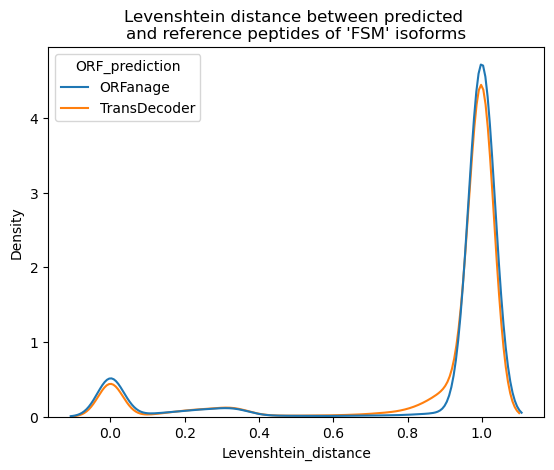

In [6]:
def get_df_for_pep(sample_pep):
    full_splice_match = sample_pep\
        .join(
            classification["isoform", "associated_transcript", "structural_category"].rename({"isoform": "transcript_id"}),
            on = "transcript_id",
            how = "left"
        )\
        .filter(pl.col("structural_category") == "full-splice_match")\
        .join(
            gencode_pep["transcript_id", "seq"].rename({"seq": "gencode_seq", "transcript_id": "associated_transcript"}),
            on = "associated_transcript",
            how = "left"
        )

    return full_splice_match\
        .with_columns(
                full_splice_match.map_rows(lambda row: ratio(row[1], row[4]))
        )\
        .rename({"map": "Levenshtein_distance"})\
        .select(["transcript_id", "Levenshtein_distance"])

df  = pl.concat(
    [
        get_df_for_pep(orfanage_pep).with_columns(ORF_prediction = pl.lit("ORFanage")), 
        get_df_for_pep(TD_pep).with_columns(ORF_prediction = pl.lit("TransDecoder"))
        ],
    how="vertical")

fig, ax = plt.subplots()
sns.kdeplot(df, x = "Levenshtein_distance", hue="ORF_prediction", ax = ax)
ax.set_title("Levenshtein distance between predicted \nand reference peptides of 'FSM' isoforms")

## Canonical isoforms

Text(0.5, 1.0, 'Levenshtein distance between predicted \nand canonical isoform')

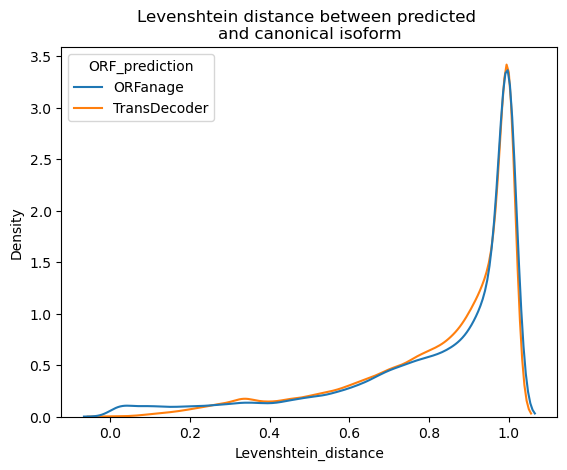

In [9]:
def get_df_for_pep(sample_pep):
    gene_to_canonical_isoform = ensembl_gtf\
        .filter(
            pl.col("feature") == "transcript",
            pl.col("attributes").str.contains("Ensembl_canonical")
        )\
        .with_columns(
            pl.when(pl.col("gene_name").is_null())\
                .then(pl.col("gene_id"))\
                .otherwise(pl.col("gene_name")).alias("gene_name")        
        )\
        .rename({"transcript_id": "canonical_isoform"})\
        .select(["canonical_isoform", "gene_name"])

    df = sample_pep\
        .join(
            classification["isoform", "structural_category", "associated_gene"].rename({"isoform": "transcript_id"}),
            on = "transcript_id",
            how = "left"
        ).drop_nulls("associated_gene")\
        .rename({"associated_gene": "gene_name"})\
        .join(
            gene_to_canonical_isoform,
            on = "gene_name",
            how = "left"
        )\
        .join(
            gencode_pep.with_columns(pl.col("transcript_id").str.split(".").map_elements(lambda s: s[0], return_dtype=pl.String))\
                .rename({"transcript_id":"canonical_isoform", "seq": "canonical_seq"}),
            on = "canonical_isoform",
            how = "left"
        )

    return df\
        .with_columns(
            df.map_rows(lambda row: ratio(row[1], row[5]))
        ).rename({"map": "Levenshtein_distance"})

df  = pl.concat(
    [
        get_df_for_pep(orfanage_pep).with_columns(ORF_prediction = pl.lit("ORFanage")), 
        get_df_for_pep(TD_pep).with_columns(ORF_prediction = pl.lit("TransDecoder"))
        ],
    how="vertical")

fig, ax = plt.subplots()
sns.kdeplot(df, x = "Levenshtein_distance", hue="ORF_prediction", ax = ax)
ax.set_title("Levenshtein distance between predicted \nand canonical isoform")

## Venn diagram

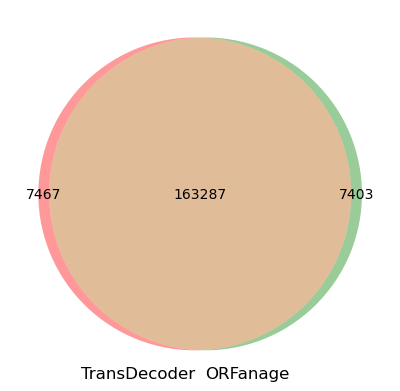

In [22]:
TransDecoder_transcripts = set(TD_pep["transcript_id"].to_list())
ORFanage_transcripts = set(orfanage_pep["transcript_id"].to_list())

venn2((TransDecoder_transcripts, ORFanage_transcripts), ("TransDecoder", "ORFanage"))

plt.show()

## Comparing TD and ORFanage

0.7844163956714252 of the transcripts that are predicted by both algorithms have identical aa sequences


<Axes: xlabel='Levenshtein_distance', ylabel='Count'>

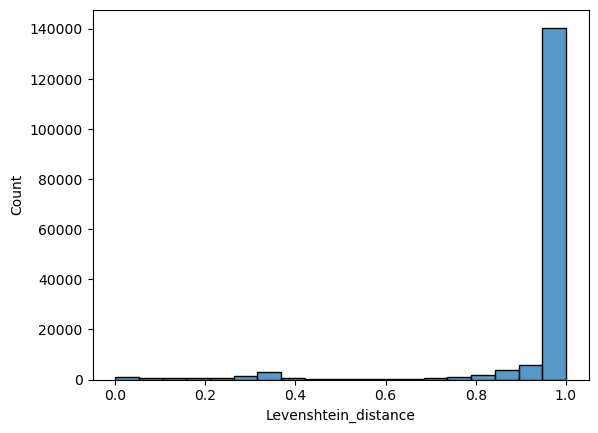

In [28]:
joined_pep = TD_pep\
    .rename({"seq": "TD_seq"})\
    .join(
        orfanage_pep.rename({"seq": "ORFanage_seq"}),
        on = "transcript_id",
        how = "inner"
    )

df = joined_pep\
    .with_columns(
        joined_pep.map_rows(lambda row: ratio(row[1], row[2]))
    ).rename({"map": "Levenshtein_distance"})

print(f"{df.filter(pl.col("Levenshtein_distance") == 1).shape[0]/df.shape[0]} of the transcripts that are predicted by both algorithms have identical aa sequences")

sns.histplot(df, x = "Levenshtein_distance")

## Transcript classification histogram

/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/plotting_functions.py:36: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("structural_category2").map_elements(lambda x: ...)
with this one instead:
  + pl.col("structural_category2").replace_strict(structural_category_labels)

  structural_category2 = pl.col("structural_category2").map_elements(lambda x: structural_category_labels[x])
/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/plotting_functions.py:35: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


null device 
          1 


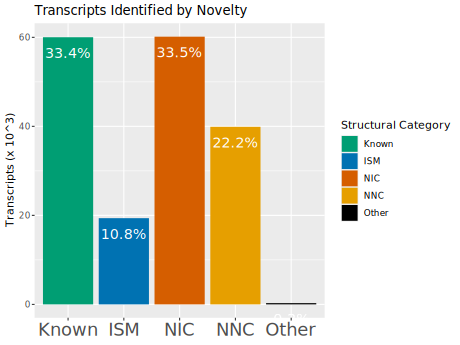

In [4]:
plot_transcript_class_hist(classification)

In [5]:
expression = pl.read_parquet("nextflow_results/v47/final_expression.parquet")

In [8]:
classification

isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,seqname,source,feature,start,end,score,strand_right,frame,attributes
str,str,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str
"""PB.14.1""","""chr1""","""+""",2328,11,"""novel_in_catalog""","""KLHL17""","""novel""",2567,12,null,null,-39,-5,"""combination_of_known_splicesit…","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""CCTCAGGCTGAGCATCTCTC""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",960584,965719,""".""","""+""",""".""","""gene_id ""ENSG00000187961.15""; …"
"""PB.14.4""","""chr1""","""+""",2402,11,"""novel_in_catalog""","""KLHL17""","""novel""",2567,12,null,null,-19,-1,"""combination_of_known_splicesit…","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""AGGCTGAGCATCTCTCTCTG""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",960584,965719,""".""","""+""",""".""","""gene_id ""ENSG00000187961.15""; …"
"""PB.14.48""","""chr1""","""+""",2401,12,"""novel_not_in_catalog""","""KLHL17""","""novel""",913,6,null,null,286,-1,"""at_least_one_novel_splicesite""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""AGGCTGAGCATCTCTCTCTG""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",960584,965719,""".""","""+""",""".""","""gene_id ""ENSG00000187961.15""; …"
"""PB.15.8""","""chr1""","""-""",3088,19,"""full-splice_match""","""NOC2L""","""ENST00000327044.7""",2757,19,-334,3,-281,-1,"""alternative_5end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""TGAGTGGTGGCTCCTGGAGA""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",944203,959309,""".""","""-""",""".""","""gene_id ""ENSG00000188976.11""; …"
"""PB.15.9""","""chr1""","""-""",2870,20,"""novel_not_in_catalog""","""NOC2L""","""novel""",2757,19,null,null,-2,51,"""at_least_one_novel_splicesite""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,35.0,"""AACACAGAGGCTGGGAAGGG""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",944203,959309,""".""","""-""",""".""","""gene_id ""ENSG00000188976.11""; …"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""PB.112777.9""","""chrY""","""+""",1389,7,"""full-splice_match""","""EIF1AY""","""ENST00000361365.7""",1339,7,-51,1,-51,-1,"""alternative_5end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,20.0,"""AGCCATTCTCAGACTGTCTC""",null,null,null,null,null,null,null,null,null,null,null,"""chrY""","""HAVANA""","""gene""",20575776,20593154,""".""","""+""",""".""","""gene_id ""ENSG00000198692.10""; …"
"""PB.112777

In [21]:
classification\
    .with_columns(
        counts = expression[:, 1:].to_numpy().sum(axis=1)
        n_unique_samples = (expression[:, 1:].to_numpy() != 0).sum(axis=0),
    )


isoform,chrom,strand,length,exons,structural_category,associated_gene,associated_transcript,ref_length,ref_exons,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS,subcategory,RTS_stage,all_canonical,min_sample_cov,min_cov,min_cov_pos,sd_cov,FL,n_indels,n_indels_junc,bite,iso_exp,gene_exp,ratio_exp,FSM_class,coding,ORF_length,CDS_length,CDS_start,CDS_end,CDS_genomic_start,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,dist_to_CAGE_peak,within_CAGE_peak,dist_to_polyA_site,within_polyA_site,polyA_motif,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,fl_assoc,cell_barcodes,seqname,source,feature,start,end,score,strand_right,frame,attributes,counts
str,str,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,i64
"""PB.14.1""","""chr1""","""+""",2328,11,"""novel_in_catalog""","""KLHL17""","""novel""",2567,12,null,null,-39,-5,"""combination_of_known_splicesit…","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""CCTCAGGCTGAGCATCTCTC""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",960584,965719,""".""","""+""",""".""","""gene_id ""ENSG00000187961.15""; …",197
"""PB.14.4""","""chr1""","""+""",2402,11,"""novel_in_catalog""","""KLHL17""","""novel""",2567,12,null,null,-19,-1,"""combination_of_known_splicesit…","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""AGGCTGAGCATCTCTCTCTG""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",960584,965719,""".""","""+""",""".""","""gene_id ""ENSG00000187961.15""; …",56
"""PB.14.48""","""chr1""","""+""",2401,12,"""novel_not_in_catalog""","""KLHL17""","""novel""",913,6,null,null,286,-1,"""at_least_one_novel_splicesite""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""AGGCTGAGCATCTCTCTCTG""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",960584,965719,""".""","""+""",""".""","""gene_id ""ENSG00000187961.15""; …",48
"""PB.15.8""","""chr1""","""-""",3088,19,"""full-splice_match""","""NOC2L""","""ENST00000327044.7""",2757,19,-334,3,-281,-1,"""alternative_5end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,15.0,"""TGAGTGGTGGCTCCTGGAGA""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",944203,959309,""".""","""-""",""".""","""gene_id ""ENSG00000188976.11""; …",55166
"""PB.15.9""","""chr1""","""-""",2870,20,"""novel_not_in_catalog""","""NOC2L""","""novel""",2757,19,null,null,-2,51,"""at_least_one_novel_splicesite""","""FALSE""","""canonical""",null,null,null,null,null,null,null,true,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,35.0,"""AACACAGAGGCTGGGAAGGG""",null,null,null,null,null,null,null,null,null,null,null,"""chr1""","""HAVANA""","""gene""",944203,959309,""".""","""-""",""".""","""gene_id ""ENSG00000188976.11""; …",402
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""PB.112777.9""","""chrY""","""+""",1389,7,"""full-splice_match""","""EIF1AY""","""ENST00000361365.7""",1339,7,-51,1,-51,-1,"""alternative_5end""","""FALSE""","""canonical""",null,null,null,null,null,null,null,false,null,null,null,"""C""","""non_coding""",null,null,null,null,null,null,null,20.0,"""AGCCATTCTCAGACTGTCTC""",null,null,null,null,null,null,null,null,null,null,null,"""chrY""","""HAVANA""","""gene""",20575776,20593154,""".""","""+""",""".""","""gene_id ""ENSG

# GENCODE V39

## Load Datasets

In [29]:
classification = pl.read_parquet("nextflow_results/v39/final_classification.parquet")

orfanage_pep = read_fasta("nextflow_results/v39/orfanage_peptide.fasta")
orfanage_stats = pl.read_csv("nextflow_results/v39/orfanage.stats", separator = "\t")

TD_gtf = read_gtf("nextflow_results/v39/transdecoder.gtf")
TD_pep = read_fasta("nextflow_results/v39/final_transcripts.fasta.transdecoder.pep")\
    .with_columns(
        pl.col("transcript_id").str.extract(r"^(.*)\.p\d+$")
    )

gencode_pep = read_fasta("".join([os.getenv("GENOMIC_DATA_DIR"), "GENCODE/gencode.v39.pc_translations.fa"]), gencode=True)
ensembl_gtf = read_gtf("".join([os.getenv("GENOMIC_DATA_DIR"), "Ensembl/Homo_sapiens.GRCh38.113.chr.gtf"]), attributes=["transcript_id", "gene_id", "gene_name"])
gencode_gtf = read_gtf("".join([os.getenv("GENOMIC_DATA_DIR"), "GENCODE/gencode.v39.annotation.gtf"]))



/gpfs/fs0/scratch/s/shreejoy/nxu/SFARI/src/utils.py:6960: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(sequences, schema=["transcript_id", "seq"])


## Reference-match isoforms

Text(0.5, 1.0, "Levenshtein distance between predicted \nand reference peptides of 'reference_match' isoforms")

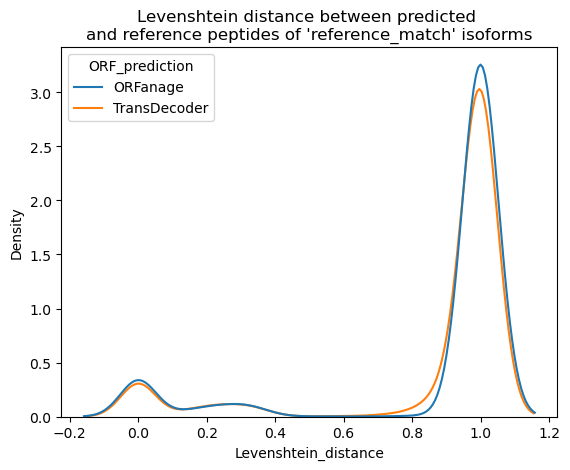

In [5]:
def get_df_for_pep(sample_pep):
    reference_match = sample_pep\
        .join(
            classification["isoform", "associated_transcript", "subcategory"].rename({"isoform": "transcript_id"}),
            on = "transcript_id",
            how = "left"
        )\
        .filter(pl.col("subcategory") == "reference_match")\
        .join(
            gencode_pep["transcript_id", "seq"].rename({"seq": "gencode_seq", "transcript_id": "associated_transcript"}),
            on = "associated_transcript",
            how = "left"
        )

    return reference_match\
        .with_columns(
                reference_match.map_rows(lambda row: ratio(row[1], row[4]))
        )\
        .rename({"map": "Levenshtein_distance"})\
        .select(["transcript_id", "Levenshtein_distance"])

df  = pl.concat(
    [
        get_df_for_pep(orfanage_pep).with_columns(ORF_prediction = pl.lit("ORFanage")), 
        get_df_for_pep(TD_pep).with_columns(ORF_prediction = pl.lit("TransDecoder"))
        ],
    how="vertical")
fig, ax = plt.subplots()
sns.kdeplot(df, x = "Levenshtein_distance", hue="ORF_prediction", ax = ax)
ax.set_title("Levenshtein distance between predicted \nand reference peptides of 'reference_match' isoforms")

## Full-splice match isoforms

Text(0.5, 1.0, "Levenshtein distance between predicted \nand reference peptides of 'FSM' isoforms")

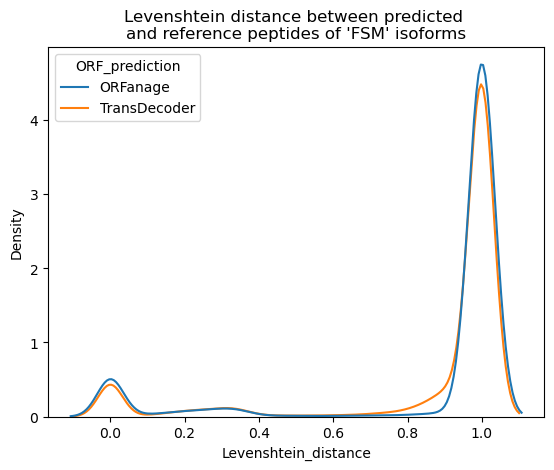

In [6]:
def get_df_for_pep(sample_pep):
    full_splice_match = sample_pep\
        .join(
            classification["isoform", "associated_transcript", "structural_category"].rename({"isoform": "transcript_id"}),
            on = "transcript_id",
            how = "left"
        )\
        .filter(pl.col("structural_category") == "full-splice_match")\
        .join(
            gencode_pep["transcript_id", "seq"].rename({"seq": "gencode_seq", "transcript_id": "associated_transcript"}),
            on = "associated_transcript",
            how = "left"
        )

    return full_splice_match\
        .with_columns(
                full_splice_match.map_rows(lambda row: ratio(row[1], row[4]))
        )\
        .rename({"map": "Levenshtein_distance"})\
        .select(["transcript_id", "Levenshtein_distance"])

df  = pl.concat(
    [
        get_df_for_pep(orfanage_pep).with_columns(ORF_prediction = pl.lit("ORFanage")), 
        get_df_for_pep(TD_pep).with_columns(ORF_prediction = pl.lit("TransDecoder"))
        ],
    how="vertical")

fig, ax = plt.subplots()
sns.kdeplot(df, x = "Levenshtein_distance", hue="ORF_prediction", ax = ax)
ax.set_title("Levenshtein distance between predicted \nand reference peptides of 'FSM' isoforms")

## Canonical isoforms

Text(0.5, 1.0, 'Levenshtein distance between predicted \nand canonical isoform')

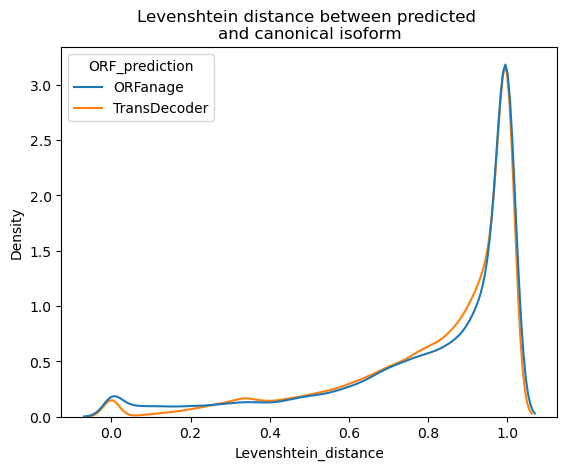

In [7]:
def get_df_for_pep(sample_pep):
    gene_to_canonical_isoform = ensembl_gtf\
        .filter(
            pl.col("feature") == "transcript",
            pl.col("attributes").str.contains("Ensembl_canonical")
        )\
        .with_columns(
            pl.when(pl.col("gene_name").is_null())\
                .then(pl.col("gene_id"))\
                .otherwise(pl.col("gene_name")).alias("gene_name")        
        )\
        .rename({"transcript_id": "canonical_isoform"})\
        .select(["canonical_isoform", "gene_name"])

    df = sample_pep\
        .join(
            classification["isoform", "structural_category", "associated_gene"].rename({"isoform": "transcript_id"}),
            on = "transcript_id",
            how = "left"
        ).drop_nulls("associated_gene")\
        .rename({"associated_gene": "gene_name"})\
        .join(
            gene_to_canonical_isoform,
            on = "gene_name",
            how = "left"
        )\
        .join(
            gencode_pep.with_columns(pl.col("transcript_id").str.split(".").map_elements(lambda s: s[0], return_dtype=pl.String))\
                .rename({"transcript_id":"canonical_isoform", "seq": "canonical_seq"}),
            on = "canonical_isoform",
            how = "left"
        )

    return df\
        .with_columns(
            df.map_rows(lambda row: ratio(row[1], row[5]))
        ).rename({"map": "Levenshtein_distance"})

df  = pl.concat(
    [
        get_df_for_pep(orfanage_pep).with_columns(ORF_prediction = pl.lit("ORFanage")), 
        get_df_for_pep(TD_pep).with_columns(ORF_prediction = pl.lit("TransDecoder"))
        ],
    how="vertical")

fig, ax = plt.subplots()
sns.kdeplot(df, x = "Levenshtein_distance", hue="ORF_prediction", ax = ax)
ax.set_title("Levenshtein distance between predicted \nand canonical isoform")

## Venn diagram

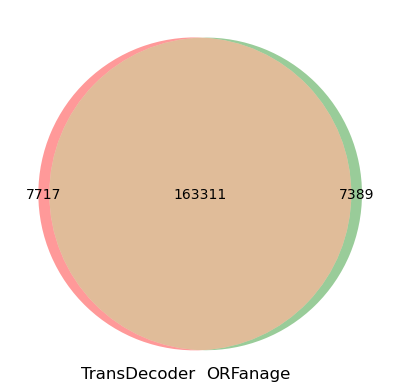

In [8]:
TransDecoder_transcripts = set(TD_pep["transcript_id"].to_list())
ORFanage_transcripts = set(orfanage_pep["transcript_id"].to_list())

venn2((TransDecoder_transcripts, ORFanage_transcripts), ("TransDecoder", "ORFanage"))

plt.show()

## Comparing TD and ORFanage

0.7850420363600737 of the transcripts that are predicted by both algorithms have identical aa sequences


<Axes: xlabel='Levenshtein_distance', ylabel='Count'>

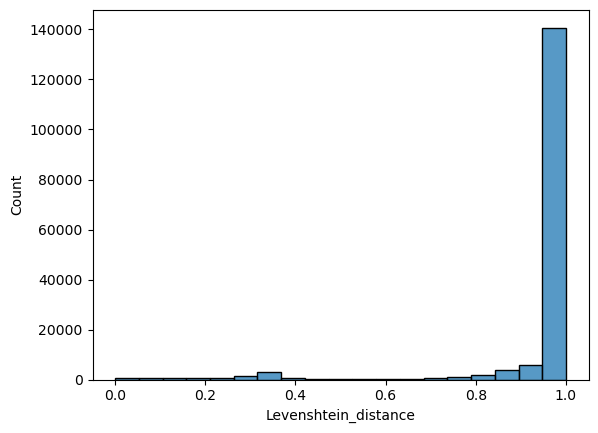

In [30]:
joined_pep = TD_pep\
    .rename({"seq": "TD_seq"})\
    .join(
        orfanage_pep.rename({"seq": "ORFanage_seq"}),
        on = "transcript_id",
        how = "inner"
    )

df = joined_pep\
    .with_columns(
        joined_pep.map_rows(lambda row: ratio(row[1], row[2]))
    ).rename({"map": "Levenshtein_distance"})

print(f"{df.filter(pl.col("Levenshtein_distance") == 1).shape[0]/df.shape[0]} of the transcripts that are predicted by both algorithms have identical aa sequences")

sns.histplot(df, x = "Levenshtein_distance")